In [1]:
import pandas as pd
import joblib
import numpy as np
import pandas as pd
import torch
import os
import torch.optim as optim
import warnings 
warnings.simplefilter('ignore')
from torch.nn import Linear,ReLU,Sigmoid
from utils import *
torch.cuda.is_available()

True

In [2]:
os.listdir('./data')

['PA_201605-2012001更新R7(20200323).xlsx',
 'pred_0997_all.csv',
 'tag盤點表20200323.xlsx',
 'tag盤點表_cleaned.csv',
 'train_cleaned.csv',
 'train_preprocessed']

In [3]:
data = joblib.load('./data/train_preprocessed')

In [4]:
tag = pd.read_csv('./data/tag盤點表_cleaned.csv')
tag_map = dict(zip(tag['TAG'],tag['chinese']))

In [5]:
critic = joblib.load('./model/net.pkl')
critic = critic.eval()
mm_x = joblib.load('./model/mm_x.pkl')
mm_y = joblib.load('./model/mm_y.pkl')

# def columns

In [6]:
x_cols = data['x_col']
y_cols = data['y_col']

In [7]:
x_cols

['MLPAP_FQ-0619.PV',
 'MLPAP_FR-0632.PV',
 'MLPAP_LIC-0738.PV',
 'MLPAP_LRC-0729.PV',
 'MLPAP_PIC-0761.PV',
 'MLPAP_TJ-0757B.PV',
 'MLPAP_TJC-0627.PV',
 'MLPAP_TJC-0757.PV',
 'MLPAP_TJC-0757A.PV',
 'MLPAP_TJC-1721.PV',
 'MLPAP_TRC-0610.PV',
 'MLPAP_TRC-0747.PV',
 'MLPAP_TRC-0762.PV',
 'MLPAP_TRC-1734.PV']

In [8]:
y_cols

['MLPAP_FQI-0997.PV']

# critic forward test

In [9]:
x = np.random.normal(loc=0,scale=1,size=(37,14))
x = pd.DataFrame(x,columns=x_cols)
x.head()

,MLPAP_FQ-0619.PV,MLPAP_FR-0632.PV,MLPAP_LIC-0738.PV,MLPAP_LRC-0729.PV,MLPAP_PIC-0761.PV,MLPAP_TJ-0757B.PV,MLPAP_TJC-0627.PV,MLPAP_TJC-0757.PV,MLPAP_TJC-0757A.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-0610.PV,MLPAP_TRC-0747.PV,MLPAP_TRC-0762.PV,MLPAP_TRC-1734.PV
0,-1.017047,-0.685447,0.105889,-0.786341,-1.543655,1.067269,1.634532,0.084712,0.355363,0.007666,1.727379,-0.543519,-0.876476,0.104870
1,0.028292,-0.128192,0.833732,-0.749326,-0.059171,-0.002697,0.503073,-1.308415,-1.278031,-1.203123,-0.157938,-0.235202,1.026941,-2.135904
2,-0.769077,-0.382599,0.685911,0.888715,0.520700,-1.222287,-1.296640,-0.767422,0.512581,0.859534,0.541822,0.362565,-0.253802,1.150641
3,-1.251030,0.407446,0.173455,-0.271947,0.167568,-0.120743,-0.781303,-0.578553,1.280388,-0.071184,1.143164,0.141063,-1.082289,0.758488
4,-1.279204,1.562517,-0.625053,-0.918011,-1.187682,0.074028,-0.658137,-0.941201,0.398135,-2.024208,1.065386,-0.399181,0.227493,-0.395632


In [10]:
y = critic(torch.tensor(x.values.reshape(-1,37*14)).cuda())
print(y)
y = mm_y.inverse_transform(y.detach().cpu().numpy())
y

tensor([[0.1858]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SigmoidBackward>)


array([[5936.88991818]])

# obj_function

In [11]:
sc_min,sc_max = mm_y.data_min_[0],mm_y.data_max_[0]
sc_min,sc_max

(5010.0884, 9998.904)

In [12]:
Y = pd.DataFrame(data['Y'],index=data['idx'])
Y = Y.loc[:'2017-03',:]
median = Y.median().values[0]
median

8057.049

In [13]:
def obj_function(x):
    # 0997 pred
    y = critic(x)
    # 還原原本區間
    y = (sc_max-sc_min)*y + sc_min
    # 計算loss
    loss = ((y-median)**2)**(0.5)
    return loss.mean()

In [14]:
x = torch.tensor(x.values.reshape(-1,37*14)).cuda()
obj_function(x)

tensor(2120.1591, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)

# build generator

In [15]:
def build_generator(input_shape,output_shape):
    net = torch.nn.Sequential(
        Linear(input_shape,256),
        ReLU(),
        Linear(256,output_shape),
        Sigmoid()
    )
    return net

In [16]:
def init_weights(m):
  if hasattr(m,'weight'):
    torch.nn.init.xavier_uniform(m.weight)
  if hasattr(m,'bias'):  
    m.bias.data.fill_(0)

In [17]:
net = build_generator(1,37*14).double().cuda()
net.apply(init_weights)
net

Sequential(
  (0): Linear(in_features=1, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=518, bias=True)
  (3): Sigmoid()
)

# noise_iter

In [18]:
noise = torch.tensor(np.random.normal(loc=0,scale=1,size=(5000,1))).cuda()
noise_datasets = torch.utils.data.TensorDataset(noise)
noise_iter = torch.utils.data.DataLoader(noise_datasets,batch_size=128)
noise_iter

# obj function

In [19]:
# not maximum 0997
#obj_function = lambda x:critic(x).mean()

# optimizer

In [20]:
optimizer = optim.Adam(net.parameters(),lr=1e-4)

# train

In [21]:
def train(net,noise_iter,obj_function,optimizer,num_epochs=100):
    train_history = []
    for epoch in range(num_epochs):
        train_avg_loss = 0
        t = 0
        for noise in noise_iter:
            noise = noise[0]
            z = net(noise).cuda()
            loss = obj_function(z)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_avg_loss += loss.item()
            t += 1
        train_avg_loss /= t
        print("epochs {} loss {:.4f}".format(epoch,train_avg_loss))
        train_history.append(train_avg_loss)
    # plt train loss
    plt.plot(np.array(train_history))
    plt.title('train loss')
    # return trained net
    return net

epochs 0 loss 669.1467
epochs 1 loss 400.2425
epochs 2 loss 327.5523
epochs 3 loss 289.1473
epochs 4 loss 240.0869
epochs 5 loss 179.7969
epochs 6 loss 108.7420
epochs 7 loss 31.1590
epochs 8 loss 7.0324
epochs 9 loss 3.9613
epochs 10 loss 2.3861
epochs 11 loss 2.3409
epochs 12 loss 2.9672
epochs 13 loss 2.3513
epochs 14 loss 1.4927
epochs 15 loss 1.8150
epochs 16 loss 1.3107
epochs 17 loss 1.9825
epochs 18 loss 1.6122
epochs 19 loss 1.1525
epochs 20 loss 1.6644
epochs 21 loss 1.0636
epochs 22 loss 1.3257
epochs 23 loss 1.2847
epochs 24 loss 1.3194
epochs 25 loss 1.3355
epochs 26 loss 1.4101
epochs 27 loss 1.0543
epochs 28 loss 1.1235
epochs 29 loss 0.9963


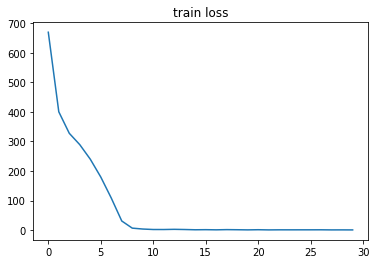

In [22]:
net = train(net,noise_iter,obj_function,optimizer,num_epochs=30)

# result

In [23]:
output = critic(net(noise)).detach().cpu().numpy()
output = mm_y.inverse_transform(output)
output = pd.DataFrame(output,columns=['0997'])
output

,0997
0,8057.013483
1,8057.093707
2,8057.118288
3,8055.149493
4,8056.963869
...,...
4995,8055.480175
4996,8057.243828
4997,8055.944423
4998,8057.131593


In [24]:
best_idx = np.argmax(output.values)
output.loc[[best_idx]]

,0997
1586,8064.571089


In [25]:
result = pd.DataFrame(net(noise).detach().cpu().numpy())
result[:] = mm_x.inverse_transform(result)
r1 = result.iloc[best_idx,:].values.reshape(37,14)
r1 = pd.DataFrame(r1,columns=x_cols)
r1.loc['median'] = r1.median(axis=0)
r1.loc['max'] = r1.max(axis=0)
r1.loc['min'] = r1.min(axis=0)
r1

,MLPAP_FQ-0619.PV,MLPAP_FR-0632.PV,MLPAP_LIC-0738.PV,MLPAP_LRC-0729.PV,MLPAP_PIC-0761.PV,MLPAP_TJ-0757B.PV,MLPAP_TJC-0627.PV,MLPAP_TJC-0757.PV,MLPAP_TJC-0757A.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-0610.PV,MLPAP_TRC-0747.PV,MLPAP_TRC-0762.PV,MLPAP_TRC-1734.PV
0,6992.002928,79.855447,36.064330,46.141548,49.443823,353.992958,149.505429,0.616248,352.022698,61.288102,179.221381,176.386215,356.825541,182.305444
1,6706.589507,80.644687,36.150429,45.663012,49.432582,354.740241,148.086417,1.067899,352.301525,62.081751,177.161694,175.901280,356.122113,181.595960
2,6449.245738,80.650008,36.073739,43.022185,49.490069,353.781328,149.541378,0.067349,352.746105,60.529021,175.314092,175.612474,358.665974,178.675048
3,6629.449905,80.399146,35.981063,43.955628,49.424753,354.746464,147.919084,0.932156,352.846242,60.015526,176.557057,174.678802,358.024983,176.956863
4,6285.881312,80.180633,36.327671,46.043271,49.407541,353.283077,149.372556,0.784386,353.388244,61.122153,175.950140,174.446653,356.507088,181.002791
5,6311.681205,79.682763,35.871753,45.347425,49.531710,349.793714,149.131472,0.544016,352.162081,61.982653,176.110098,175.966951,355.248849,179.981303
6,6504.184143,80.454602,35.905551,44.799569,49.420076,359.256752,149.533150,0.310740,353.682529,62.935491,175.838616,174.855150,356.904807,179.128974
7,6396.777484,80.330714,35.699144,45.385671,49.471271,354.385055,149.630765,0.704278,353.382893,61.300737,177.257144,175.910753,360.294964,174.413352
8,7086.843347,80.821758,35.820641,44.671251,49.493403,353.378871,148.337230,0.057781,353.225505,60.086265,177.669771,176.500265,356.575268,181.943601
9,6564.811062,78.426853,36.112185,46.013165,49.431146,355.947584,149.090978,0.843240,354.409783,59.709836,176.819007,175.664517,359.673289,183.225312


In [26]:
r1 = r1.iloc[-3:].T
r1['chinese'] = r1.index.map(tag_map)
r1 = r1[['chinese','median','max','min']]

In [27]:
print('best control factor maybe:')
r1

best control factor maybe:


,chinese,median,max,min
MLPAP_FQ-0619.PV,OX入料量,6718.343431,7086.843347,5987.208036
MLPAP_FR-0632.PV,汽機風量,80.120919,81.902361,65.616532
MLPAP_LIC-0738.PV,汽鼓(V211)鍋爐水液位,35.997835,36.620393,34.921262
MLPAP_LRC-0729.PV,鍋爐水液位控制,45.173302,48.097481,39.860620
MLPAP_PIC-0761.PV,鹽浴冷卻器(E112)出口壓力,49.460402,49.531710,49.347444
MLPAP_TJ-0757B.PV,反應槽鹽浴溫度,354.607536,359.256752,349.793714
MLPAP_TJC-0627.PV,OX預熱器出口溫度,149.505429,153.153445,146.390365
MLPAP_TJC-0757.PV,反應器A/B側鹽浴溫度差,0.616248,1.484523,0.027304
MLPAP_TJC-0757A.PV,反應槽鹽浴溫度,353.225505,354.974896,348.733012
MLPAP_TJC-1721.PV,轉換式冷凝器冷油溫度,60.608815,62.935491,58.549247


In [28]:
r1.iloc[0,1]/output.loc[[best_idx]]

,0997
1586,0.833069
